In [183]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import seaborn as sns


# to be able to use .head(100) to see more rows of df
pd.set_option("display.max_rows", 100, "display.max_columns", None)
pd.set_option('use_inf_as_na', True)

In [184]:
# read the data
df = pd.read_csv('dataset_mood_smartphone.csv', index_col=0)

# get dates from timestamp
df['time']= pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date

# Feature Engineering setup

In [185]:
def sleep_calculation(df):
    data = df.copy()
    sleep_per_user = []
    
    # iterate over unique users
    for user in data['id'].unique():

        # gather user's data
        df_user = data[data['id'] == user]

        # iterate over unique dates
        for day in pd.to_datetime(df_user["time"]).map(pd.Timestamp.date).unique():
#             print(day)

            # define start and end of the night
            start_night = pd.Timestamp(day) - pd.Timedelta(3, 'h')
            end_night = pd.Timestamp(day) + pd.Timedelta(9, 'h')
            
            # get all the times of measurements during the night
            time_deltas = df_user[(df_user['time'] >= start_night) & (df_user['time'] < end_night)]['time'].values

            # calculate sleep as the largest interval between measurements, if more than one measurement
            if len(time_deltas) > 1:
                sleep = int(max(abs(x - y) for (x, y) in zip(time_deltas[1:], time_deltas[:-1])) / np.timedelta64(1, 'h'))

            # otherwise, set sleep to 12 (changeable)
            else:
                sleep = 12

            sleep_per_user.append({'id':user, 'time':pd.Timestamp(day), 'date':day, 'variable':'sleep', 'value': sleep})
            
    return sleep_per_user

In [186]:
# add sleep to df
sleep_per_user = sleep_calculation(df)
df = df.append(pd.DataFrame(sleep_per_user))

In [187]:
def names_col(df,add):
    dic = {}
    for i in df.columns:
       dic[i] = f'{add}_{i}'
    return dic

In [188]:

df_std = df.groupby(['id', 'date', 'variable'])['value'].std().unstack()
df_std .rename(columns = names_col(df_std,'std'), inplace = True)

df_count = df.groupby(['id', 'date', 'variable'])['value'].count().unstack()
df_count .rename(columns = names_col(df_count,'count'), inplace = True)

df_var = df.groupby(['id', 'date', 'variable'])['value'].var().unstack()
df_var .rename(columns = names_col(df_var,'var'), inplace = True)

df_min = df.groupby(['id', 'date', 'variable'])['value'].min().unstack()
df_min .rename(columns = names_col(df_min,'min'), inplace = True)

df_max = df.groupby(['id', 'date', 'variable'])['value'].max().unstack()
df_max .rename(columns = names_col(df_max,'max'), inplace = True)

df_sum_1 = df.groupby(['id', 'date', 'variable'])['value'].sum().unstack()
df_sum_1.rename(columns = names_col(df_sum_1,'sum'), inplace = True)

df_mean_1 = df.groupby(['id', 'date', 'variable'])['value'].mean().unstack()
df_mean_1.rename(columns = names_col(df_mean_1,'mean'), inplace = True)

In [189]:
# turn 'variable' into separate columns, taking sum of values per day per user
df_sum = df.groupby(['id', 'date', 'variable'])['value'].sum().unstack()

# turn 'variable' into separate columns, taking mean of values per day per user
df_mean = df.groupby(['id', 'date', 'variable'])['value'].mean().unstack()

In [190]:
# combine mean of score values and sum of time values into one dataframe
df_combi = df_sum
df_combi['mood'] = df_mean['mood']
df_combi['circumplex.arousal'] = df_mean['circumplex.arousal']
df_combi['circumplex.valence'] = df_mean['circumplex.valence']
df_combi['activity'] = df_mean['activity']
df_combi.columns.name = None

In [191]:
df_to_rol = df_combi.reset_index(level='id')
df_rolled = df_to_rol.groupby('id').rolling(7, min_periods=5).mean()

In [192]:
df_rolled = pd.concat([df_rolled, df_std],axis=1)
df_rolled = pd.concat([df_rolled, df_count],axis=1)
df_rolled = pd.concat([df_rolled, df_var],axis=1)
df_rolled = pd.concat([df_rolled, df_min],axis=1)
df_rolled = pd.concat([df_rolled, df_max],axis=1)
df_rolled = pd.concat([df_rolled, df_sum_1],axis=1)
df_rolled = pd.concat([df_rolled, df_mean_1],axis=1)

In [193]:
df_rolled

activity  appCat.builtin  appCat.communication  \
id      date                                                         
AS14.01 2014-02-17       NaN             NaN                   NaN   
        2014-02-18       NaN             NaN                   NaN   
        2014-02-19       NaN             NaN                   NaN   
        2014-02-20       NaN             NaN                   NaN   
        2014-02-21       NaN             NaN                   NaN   
...                      ...             ...                   ...   
AS14.33 2014-05-27  0.050424     1114.687286           1578.840143   
        2014-05-28  0.062727     1384.596857           1596.197714   
        2014-05-29  0.085272     1334.634571           1476.610429   
        2014-05-30  0.109888     1629.403714           1598.222571   
        2014-05-31  0.125822     1742.983167           1487.274333   

                    appCat.entertainment  appCat.finance  appCat.game  \
id      date                                                            
AS14.01 2014-02-17                   NaN             NaN          NaN   
        2014-02-18                   NaN             NaN          NaN   
        2014-02-19                   NaN             NaN          NaN   
        2014-02-20                   NaN             NaN          NaN   
        2014-02-21                   NaN             NaN          NaN   
...                                  ...             ...          ...   
AS14.33 2014-05-27            643.566143             NaN          NaN   
        2014-05-28            579.009571             NaN          NaN   
        2014-05-29            559.904286             NaN          NaN   
        2014-05-30            449.908286             NaN          NaN   
        2014-05-31            336.557167             NaN          NaN   

                    appCat.office  appCat.other  appCat.social  appCat.travel  \
id      date                                                                    
AS14.01 2014-02-17            NaN           NaN            NaN            NaN   
        2014-02-18            NaN           NaN            NaN            NaN   
        2014-02-19            NaN           NaN            NaN            NaN   
        2014-02-20            NaN           NaN            NaN            NaN   
        2014-02-21            NaN           NaN            NaN            NaN   
...                           ...           ...            ...            ...   
AS14.33 2014-05-27            NaN    103.484714    4355.564000            NaN   
        2014-05-28            NaN    169.488286    4251.058286            NaN   
        2014-05-29            NaN    166.339571    4230.720571            NaN   
        2014-05-30            NaN    158.724857    3762.880000            NaN   
        2014-05-31            NaN    172.107167    3439.640167            NaN   

                    appCat.unknown  appCat.utilities  appCat.weather  \
id      date                                                           
AS14.01 2014-02-17             NaN               NaN             NaN   
        2014-02-18             NaN               NaN             NaN   
        2014-02-19             NaN               NaN             NaN   
        2014-02-20             NaN               NaN             NaN   
        2014-02-21             NaN               NaN             NaN   
...                            ...               ...             ...   
AS14.33 2014-05-27             NaN               NaN             NaN   
        2014-05-28             NaN               NaN             NaN   
        2014-05-29             NaN               NaN             NaN   
        2014-05-30             NaN            83.969             NaN   
        2014-05-31             NaN            83.969             NaN   

                        call  circumplex.arousal  circumplex.valence  \
id      date                                                           
AS14.01 2014-02-17      

In [194]:
df_rolled = df_rolled.dropna(axis = 0, how = 'all')
df_rolled = df_rolled.dropna(subset=['mood','screen'], how='all')
df_rolled = df_rolled.reset_index(level='id')
df_rolled = df_rolled.reset_index(level='date')

In [195]:
# determine whether date is a weekend day or not
def weekend(df):
    data = df.copy()
    weekend_bools = {}
    
    # iterate over unique dates
    for date in data['date'].unique():
        
        # check day of the week (5 and 6 are saturday and sunday)
        if date.weekday() > 4:
            weekend_bools[date] = 1
        else:
            weekend_bools[date] = 0
            
    return weekend_bools

In [196]:
# add weekend bools to df
weekend_bools = weekend(df_rolled)
df_rolled['weekend'] = df_rolled['date'].map(weekend_bools)

In [197]:
def geneva_emo_wheel(df):
    for index, row in df.iterrows():
        #neutral
        if 0 == row['circumplex.arousal'] and 0 == row['circumplex.valence']:
            df.loc[index, 'emo_wheel'] = 0
        
        #high arousal positive valance
        if 0 <= row['circumplex.arousal'] and 0 <= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 1
         
        #low arousal positive valance    
        elif 0 >= row['circumplex.arousal'] and 0 <= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 2
        
        #high arousal negative valance
        elif 0 <= row['circumplex.arousal'] and 0 >= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 3
       
        #low arousal negative valance
        elif 0 >= row['circumplex.arousal'] and 0 >= row['circumplex.valence']: 
            df.loc[index, 'emo_wheel'] = 4
        else:
             df.loc[index, 'emo_wheel'] = 0
    return df

In [198]:
df_rolled['emo_wheel'] = 0
df_rolled = geneva_emo_wheel(df_rolled)

In [199]:
df_rolled = df_rolled[df_rolled.columns.tolist()[:2]+['weekend', 'emo_wheel']+df_rolled.columns.tolist()[2:-2]]
df_rolled

,date,id,weekend,emo_wheel,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sleep,sms,std_activity,std_appCat.builtin,std_appCat.communication,std_appCat.entertainment,std_appCat.finance,std_appCat.game,std_appCat.office,std_appCat.other,std_appCat.social,std_appCat.travel,std_appCat.unknown,std_appCat.utilities,std_appCat.weather,std_call,std_circumplex.arousal,std_circumplex.valence,std_mood,std_screen,std_sleep,std_sms,count_activity,count_appCat.builtin,count_appCat.communication,count_appCat.entertainment,count_appCat.finance,count_appCat.game,count_appCat.office,count_appCat.other,count_appCat.social,count_appCat.travel,count_appCat.unknown,count_appCat.utilities,count_appCat.weather,count_call,count_circumplex.arousal,count_circumplex.valence,count_mood,count_screen,count_sleep,count_sms,var_activity,var_appCat.builtin,var_appCat.communication,var_appCat.entertainment,var_appCat.finance,var_appCat.game,var_appCat.office,var_appCat.other,var_appCat.social,var_appCat.travel,var_appCat.unknown,var_appCat.utilities,var_appCat.weather,var_call,var_circumplex.arousal,var_circumplex.valence,var_mood,var_screen,var_sleep,var_sms,min_activity,min_appCat.builtin,min_appCat.communication,min_appCat.entertainment,min_appCat.finance,min_appCat.game,min_appCat.office,min_appCat.other,min_appCat.social,min_appCat.travel,min_appCat.unknown,min_appCat.utilities,min_appCat.weather,min_call,min_circumplex.arousal,min_circumplex.valence,min_mood,min_screen,min_sleep,min_sms,max_activity,max_appCat.builtin,max_appCat.communication,max_appCat.entertainment,max_appCat.finance,max_appCat.game,max_appCat.office,max_appCat.other,max_appCat.social,max_appCat.travel,max_appCat.unknown,max_appCat.utilities,max_appCat.weather,max_call,max_circumplex.arousal,max_circumplex.valence,max_mood,max_screen,max_sleep,max_sms,sum_activity,sum_appCat.builtin,sum_appCat.communication,sum_appCat.entertainment,sum_appCat.finance,sum_appCat.game,sum_appCat.office,sum_appCat.other,sum_appCat.social,sum_appCat.travel,sum_appCat.unknown,sum_appCat.utilities,sum_appCat.weather,sum_call,sum_circumplex.arousal,sum_circumplex.valence,sum_mood,sum_screen,sum_sleep,sum_sms,mean_activity,mean_appCat.builtin,mean_appCat.communication,mean_appCat.entertainment,mean_appCat.finance,mean_appCat.game,mean_appCat.office,mean_appCat.other,mean_appCat.social,mean_appCat.travel,mean_appCat.unknown,mean_appCat.utilities,mean_appCat.weather,mean_call,mean_circumplex.arousal,mean_circumplex.valence,mean_mood,mean_screen,mean_sleep,mean_sms
0,2014-03-24,AS14.01,0,0,0.134836,1254.565600,5583.997000,504.590600,NaN,NaN,NaN,97.724000,1976.065600,NaN,NaN,189.253400,NaN,3.666667,NaN,NaN,NaN,9643.639000,9.714286,NaN,0.104793,5.995683,99.211132,217.434086,1.639527,NaN,NaN,1.711579,114.370936,168.371806,NaN,112.149964,NaN,0.0,1.303840,0.707107,0.707107,154.984715,NaN,NaN,24.0,174.0,195.0,8.0,6.0,NaN,1.0,6.0,43.0,5.0,NaN,2.0,NaN,10.0,5.0,5.0,5.0,196.0,1.0,NaN,0.010981,35.948217,9842.848685,47277.581787,2.688049,NaN,NaN,2.929504,13080.710938,28349.064955,NaN,12577.614408,NaN,0.0,1.700000,0.500000,0.500000,24020.261788,NaN,NaN,0.0,0.631,1.617,5.011,4.008,NaN,3.010,9.022,1.437,1.910,NaN,10.064,NaN,1.0,-1.0,-1.0,5.0,0.683,11.0,NaN,0.361345,53.390,912.431,591.054,8.025,NaN,3.010,13.093,609.847,384.800,NaN,168.668,NaN,1.0,2.0,1.0,7.0,1125.418,11.0,NaN,1.895065,866.956,9270.629,976.971,34.106,NaN,3.010,66.558,3223.626,419.805,NaN,178.732,NaN,10.0,4.0,0.0,30.0,15047.351001,11.0,NaN,0.078961,4.982506,47.541687,122.121375,5.684333,NaN,3.010000,11.093000,74.968047,83.961000,NaN,89.366000,NaN,1.0,0.800000,0.0,6.00,76.772199,11.0,NaN
1,2014-03-25,AS14.01,0,1,0.128759,1217.599333,6366.122667,431.859833,38.236600,NaN,NaN,111.239833,1966.633167,NaN,NaN,194.860000,NaN,4.200000,0.460000,0.400000,6.430000,11615.591667

In [200]:
corr = df_rolled[2:].corr()
x = corr[['mood']]
x_sub = x[(x['mood'] >=0.15) | (x['mood'] <=-0.15)]

In [201]:
x_sub.style.background_gradient(cmap='coolwarm')

,mood
emo_wheel,-0.206950
activity,0.198343
appCat.entertainment,0.266917
appCat.office,0.194052
appCat.other,0.176495
appCat.weather,0.766930
circumplex.valence,0.578073
mood,1.000000
std_appCat.weather,0.183833
std_circumplex.valence,-0.169213


#### Atributes

In [202]:
attributes = ['id', 'date', 'weekend', 'sleep'] + x_sub.index.tolist()

In [203]:
df_sub = df_rolled[attributes]

In [204]:
#drop empty mood and fil NaN with zero
df_sub = df_sub.dropna(subset=['mood'], how='all')
df_sub = df_sub.replace([np.inf, -np.inf],0)
df_sub = df_sub.fillna(0)

In [205]:
# Remove outliers by only keeping values within 3 mad from the median
for column in df_sub.columns.tolist()[2:]: 
    
    median = df_sub[column].median()
    mad = df_sub[column].mad()
    
    outliers = df_sub[(df_sub[column] >= median+(3*mad)) & (df_sub[column] <= median-(3*mad))][column]
    df_sub = df_sub.replace(to_replace=outliers, value=0)

In [ ]:
def remove_outlier(df):

    for column in ['Voeg', 'columns', 'in']: 
    
    median = df[column].median()
    mad = df[column].mad()
    
    outliers = df[(df[column] >= median+(3*mad)) & (df[column] <= median-(3*mad))][column]
    df = df.replace(to_replace=outliers, value=0)

In [206]:
df_sub = df_sub.drop(['date'],axis = 1)
df_sub =  pd.get_dummies(df_sub, prefix='id')

In [207]:
for i in df_sub.columns.tolist(): #>>>> aangepast
    if not i == 'mean_mood': 
        df_sub[i]=(df_sub[i]-df_sub[i].min())/(df_sub[i].max()-df_sub[i].min())

# Models

In [208]:
from sklearn.model_selection import TimeSeriesSplit



X_base = df_sub.drop('mean_mood', axis=1)
X_train_all = pd.DataFrame(columns= X_base.columns)
X_test_all = pd.DataFrame(columns= X_base.columns)
X_val_all = pd.DataFrame(columns= X_base.columns)
y_train_all = pd.DataFrame()
y_test_all = pd.DataFrame()
y_val_all = pd.DataFrame()

for i in df.id.unique():
    dfid = df_sub[df_sub['id_'+ i] == 1]
    
    y = dfid['mean_mood']
    
    X = dfid.drop('mean_mood', axis = 1)
    
    len_1 = int(len(X) * 0.8)
    len_11 = len(X) - len_1
    
    X_train_sub = X.head(len_1)
    X_test = X.tail(len_11)
    
    y_train_sub = y.head(len_1)
    y_test = y.tail(len_11)
    
    len_2 = int(len(X_train_sub)* 0.8)
    len_22 = len(X_train_sub) - len_2 
    
    X_train = X_train_sub.head(len_2)
    X_val = X_train_sub.tail(len_22)
    
    y_train = y_train_sub.head(len_2)
    y_val = y_train_sub.tail(len_22)


    X_train_all = pd.concat([X_train_all, X_train])
    X_test_all = pd.concat([X_test_all, X_test])
    X_val_all= pd.concat([X_val_all,X_val])
    y_train_all= pd.concat([y_train_all,y_train])
    y_test_all = pd.concat([y_test_all,y_test])
    y_val_all = pd.concat([y_val_all,y_val])

In [209]:
 len(X_train_all), len(X_test_all), len(X_val_all)

(736, 245, 198)

In [210]:
len(y_train_all),len( y_test_all ), len( y_val_all )

(736, 245, 198)

## Feature Engineering Models

### Linear Regression

In [211]:
lreg = LinearRegression().fit(X_train_all, y_train_all)

# calculate regression metrics
lreg_mse = metrics.mean_squared_error(lreg.predict(X_test_all), y_test_all, squared=True)
lreg_rmse = metrics.mean_squared_error(lreg.predict(X_test_all), y_test_all, squared=False)
lreg_r2 = metrics.r2_score(lreg.predict(X_test_all), y_test_all)
lreg_acc = lreg.score(X_test_all, y_test_all)

print(f'MSE = {lreg_mse}, RMSE = {lreg_rmse}, R2 = {lreg_r2}, accuracy = {lreg_acc}')
lreg_scores = {'model': 'Linear Regression', 'MSE':lreg_mse, 'RMSE':lreg_rmse, 'R2':lreg_r2, 'accuracy':lreg_acc}

MSE = 0.06693424207553351, RMSE = 0.25871652841581944, R2 = 0.980134971598754, accuracy = 0.9818441400003927


### Least-angle regression (LARS)

In [212]:
from sklearn import linear_model
lars = linear_model.Lars(n_nonzero_coefs=21, normalize=False).fit(X_train_all, y_train_all)

# calculate regression metrics
lars_mse = metrics.mean_squared_error(lars.predict(X_test_all), y_test_all, squared=True)
lars_rmse = metrics.mean_squared_error(lars.predict(X_test_all), y_test_all, squared=False)
lars_r2 = metrics.r2_score(lars.predict(X_test_all), y_test_all)
lars_acc = lars.score(X_test_all, y_test_all)

print(f'MSE = {lars_mse}, RMSE = {lars_rmse}, R2 = {lars_r2}, accuracy = {lars_acc}')
lars_scores = {'model': ' Least-angle regression ', 'MSE':lars_mse, 'RMSE':lars_rmse, 'R2':lars_r2, 'accuracy':lars_acc}

MSE = 0.06365175276155559, RMSE = 0.25229298991758686, R2 = 0.9796977031105109, accuracy = 0.9827345126196498


### Multi-layer Perceptron regressor.

In [213]:
from sklearn.neural_network import MLPRegressor
mlp = MLPRegressor(random_state=1, max_iter=500).fit(X_train_all, y_train_all)

# calculate regression metrics
mlp_mse = metrics.mean_squared_error(mlp.predict(X_test_all), y_test_all, squared=True)
mlp_rmse = metrics.mean_squared_error(mlp.predict(X_test_all), y_test_all, squared=False)
mlp_r2 = metrics.r2_score(mlp.predict(X_test_all), y_test_all)
mlp_acc = mlp.score(X_test_all, y_test_all)

print(f'MSE = {mlp_mse}, RMSE = {mlp_rmse}, R2 = {mlp_r2}, accuracy = {mlp_acc}')
mlp_scores = {'model': 'Multi-layer Perceptron regressor', 'MSE':mlp_mse, 'RMSE':mlp_rmse, 'R2':mlp_r2, 'accuracy':mlp_acc}

C:\Users\julia\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE = 0.10816029282283508, RMSE = 0.3288773218433206, R2 = 0.9661390824002883, accuracy = 0.9706616064795072


### Kernel Ridge

In [214]:
from sklearn.kernel_ridge import KernelRidge
kr = KernelRidge(alpha=0.057).fit(X_train_all, y_train_all)

# calculate regression metrics
kr_mse = metrics.mean_squared_error(kr.predict(X_test_all), y_test_all, squared=True)
kr_rmse = metrics.mean_squared_error(kr.predict(X_test_all), y_test_all, squared=False)
kr_r2 = metrics.r2_score(kr.predict(X_test_all), y_test_all)
kr_acc = kr.score(X_test_all, y_test_all)

print(f'MSE = {kr_mse}, RMSE = {kr_rmse}, R2 = {kr_r2}, accuracy = {kr_acc}')
kr_scores = {'model': 'Kernel Ridge', 'MSE':kr_mse, 'RMSE':kr_rmse, 'R2':kr_r2, 'accuracy':kr_acc}

MSE = 0.06434019750393873, RMSE = 0.25365369601868354, R2 = 0.9807025937606938, accuracy = 0.9825477725300845


### Support Vector Regression

In [215]:
from sklearn import svm
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
svr = svm.SVR(kernel='poly', degree = 5)
svr.fit(X_train_all, y_train_all)
svr.score(X_test_all, y_test_all)

svr_mse = metrics.mean_squared_error(svr.predict(X_test_all), y_test_all, squared=True)
svr_rmse = metrics.mean_squared_error(svr.predict(X_test_all), y_test_all, squared=False)
svr_r2 = metrics.r2_score(svr.predict(X_test_all), y_test_all)
svr_acc = svr.score(X_test_all, y_test_all)

print(f'MSE = {svr_mse}, RMSE = {svr_rmse}, R2 = {svr_r2}, accuracy = {svr_acc}')
svr_scores = {'model': 'Support Vector Regression', 'MSE':svr_mse, 'RMSE':svr_rmse, 'R2':svr_r2, 'accuracy':svr_acc}

MSE = 2.0411126721363813, RMSE = 1.4286751457684077, R2 = -2.336178851685873, accuracy = 0.4463498088629517


C:\Users\julia\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [216]:
svrp = make_pipeline(StandardScaler(), svm.SVR(C=1.0, epsilon=0.1))
svrp.fit(X_train_all, y_train_all)
svrp.score(X_test_all, y_test_all)

svrp_mse = metrics.mean_squared_error(svrp.predict(X_test_all), y_test_all, squared=True)
svrp_rmse = metrics.mean_squared_error(svrp.predict(X_test_all), y_test_all, squared=False)
svrp_r2 = metrics.r2_score(svrp.predict(X_test_all), y_test_all)
svrp_acc = svrp.score(X_test_all, y_test_all)

print(f'MSE = {svrp_mse}, RMSE = {svrp_rmse}, R2 = {svrp_r2}, accuracy = {svrp_acc}')
svrp_scores = {'model': 'Support Vector Regression Pipeline', 'MSE':svrp_mse, 'RMSE':svrp_rmse, 'R2':svrp_r2, 'accuracy':svrp_acc}

C:\Users\julia\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE = 1.0419013130868822, RMSE = 1.0207356724867032, R2 = 0.13186636617607317, accuracy = 0.7173850963686779


In [217]:
scores = [lreg_scores, lars_scores, mlp_scores, kr_scores, svr_scores, svrp_scores]
df_scores = pd.DataFrame(scores).set_index('model')
df_scores.index.name = None
df_scores

,MSE,RMSE,R2,accuracy
Linear Regression,0.066934,0.258717,0.980135,0.981844
Least-angle regression,0.063652,0.252293,0.979698,0.982735
Multi-layer Perceptron regressor,0.108160,0.328877,0.966139,0.970662
Kernel Ridge,0.064340,0.253654,0.980703,0.982548
Support Vector Regression,2.041113,1.428675,-2.336179,0.446350
Support Vector Regression Pipeline,1.041901,1.020736,0.131866,0.717385


In [218]:
lars = linear_model.Lars(n_nonzero_coefs=21, normalize=False).fit(X_train_all, y_train_all)

lars_mse = metrics.mean_squared_error(lars.predict(X_test_all), y_test_all, squared=True)
lars_rmse = metrics.mean_squared_error(lars.predict(X_test_all), y_test_all, squared=False)
lars_r2 = metrics.r2_score(lars.predict(X_test_all), y_test_all)
lars_acc = lars.score(X_test_all, y_test_all)

print(f'MSE = {lars_mse}, RMSE = {lars_rmse}, R2 = {lars_r2}, accuracy = {lars_acc}')

MSE = 0.06365175276155559, RMSE = 0.25229298991758686, R2 = 0.9796977031105109, accuracy = 0.9827345126196498


In [219]:
lreg = LinearRegression().fit(X_train_all, y_train_all)

# calculate regression metrics
lreg_mse = metrics.mean_squared_error(lreg.predict(X_test_all), y_test_all, squared=True)
lreg_rmse = metrics.mean_squared_error(lreg.predict(X_test_all), y_test_all, squared=False)
lreg_r2 = metrics.r2_score(lreg.predict(X_test_all), y_test_all)
lreg_acc = lreg.score(X_test_all, y_test_all)

print(f'MSE = {lreg_mse}, RMSE = {lreg_rmse}, R2 = {lreg_r2}, accuracy = {lreg_acc}')
lreg_scores = {'model': 'Linear Regression', 'MSE':lreg_mse, 'RMSE':lreg_rmse, 'R2':lreg_r2, 'accuracy':lreg_acc}

MSE = 0.06693424207553351, RMSE = 0.25871652841581944, R2 = 0.980134971598754, accuracy = 0.9818441400003927


In [220]:
mlp = MLPRegressor(random_state=1, max_iter=500).fit(X_train_all, y_train_all)

# calculate regression metrics
mlp_mse = metrics.mean_squared_error(mlp.predict(X_test_all), y_test_all, squared=True)
mlp_rmse = metrics.mean_squared_error(mlp.predict(X_test_all), y_test_all, squared=False)
mlp_r2 = metrics.r2_score(mlp.predict(X_test_all), y_test_all)
mlp_acc = mlp.score(X_test_all, y_test_all)

print(f'MSE = {mlp_mse}, RMSE = {mlp_rmse}, R2 = {mlp_r2}, accuracy = {mlp_acc}')

C:\Users\julia\anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


MSE = 0.10816029282283508, RMSE = 0.3288773218433206, R2 = 0.9661390824002883, accuracy = 0.9706616064795072


# Statistics

In [221]:
def score_per_user(model, X, Y):
    users = df.id.unique()
    df_complete = X.copy()
    df_complete['Y'] = Y
    maes = []
    rmses = []
    r2s = []
    for user in users:
        print(user)
        display(X)
        df_user = df_complete[df_complete[f'id_{user}'] == 1]
        X_user = df_user.drop('Y', axis=1)
        Y_user = df_user['Y']
        
        maes.append(metrics.mean_absolute_error(model.predict(X_user), Y_user))
        rmses.append(metrics.mean_squared_error(model.predict(X_user), Y_user, squared=False))
        r2s.append(metrics.r2_score(model.predict(X_user), Y_user))
    
    return {'mae':maes, 'rmse':rmses, 'r2':r2s}

score_f = score_per_user(lars, X_test_all, y_test_all)

AS14.01


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.02


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.03


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.05


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.06


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.07


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.08


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.09


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.12


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.13


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.14


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.15


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.16


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.17


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.19


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.20


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.23


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.24


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.25


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.26


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.27


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.28


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.29


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.30


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.31


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.32


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


AS14.33


,weekend,sleep,emo_wheel,activity,appCat.entertainment,appCat.office,appCat.other,appCat.weather,circumplex.valence,mood,std_appCat.weather,std_circumplex.valence,std_mood,count_appCat.entertainment,count_appCat.office,count_appCat.other,var_appCat.weather,var_mood,min_appCat.utilities,min_appCat.weather,min_circumplex.valence,min_mood,max_circumplex.valence,max_mood,sum_appCat.entertainment,sum_circumplex.valence,sum_mood,mean_appCat.weather,mean_circumplex.valence,id_AS14.01,id_AS14.02,id_AS14.03,id_AS14.05,id_AS14.06,id_AS14.07,id_AS14.08,id_AS14.09,id_AS14.12,id_AS14.13,id_AS14.14,id_AS14.15,id_AS14.16,id_AS14.17,id_AS14.19,id_AS14.20,id_AS14.23,id_AS14.24,id_AS14.25,id_AS14.26,id_AS14.27,id_AS14.28,id_AS14.29,id_AS14.30,id_AS14.31,id_AS14.32,id_AS14.33
34,1.0,0.923077,0.333333,0.209068,0.125638,0.0,0.121552,0.0,0.730825,0.775837,0.0,0.000000,0.163299,0.036545,0.000000,0.212766,0.0,0.026667,0.002779,0.0,0.75,0.777778,0.666667,0.8,0.087220,0.714286,0.612245,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,0.0,0.884615,0.333333,0.182356,0.148011,0.0,0.122844,0.0,0.713459,0.775837,0.0,0.210819,0.154919,0.046512,0.000000,0.127660,0.0,0.024000,0.005525,0.0,0.50,0.777778,0.666667,0.8,0.089428,0.642857,0.775510,0.0,0.630769,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36,0.0,0.858974,0.333333,0.185868,0.155019,0.0,0.120827,0.0,0.713459,0.758370,0.0,0.000000,0.282843,0.079734,0.000000,0.106383,0.0,0.080000,0.002721,0.0,0.75,0.666667,0.666667,0.8,0.090242,0.571429,0.714286,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,0.0,0.846154,0.333333,0.219942,0.157409,0.0,0.133574,0.0,0.691751,0.767103,0.0,0.235702,0.126491,0.049834,0.000000,0.170213,0.0,0.016000,0.002757,0.0,0.50,0.777778,0.666667,0.8,0.029158,0.571429,0.795918,0.0,0.615385,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.846154,0.333333,0.215454,0.096766,0.0,0.134685,0.0,0.691751,0.784571,0.0,0.000000,0.000000,0.026578,0.004630,0.127660,0.0,0.000000,0.002771,0.0,0.75,0.888889,0.666667,0.8,0.027194,0.714286,0.816327,0.0,0.692308,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1191,0.0,0.730769,0.333333,0.114472,0.068399,0.0,0.064399,0.0,0.230101,0.310044,0.0,0.421637,0.236643,0.006645,0.000000,0.170213,0.0,0.056000,0.002754,0.0,0.25,0.555556,0.666667,0.7,0.007202,0.500000,0.632653,0.0,0.507692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1192,0.0,0.769231,0.333333,0.142402,0.061538,0.0,0.105474,0.0,0.351664,0.406114,0.0,0.394405,0.464758,0.046512,0.037037,0.404255,0.0,0.216000,0.008337,0.0,0.50,0.666667,1.000000,1.0,0.035501,0.785714,0.836735,0.0,0.753846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1193,0.0,0.769231,0.333333,0.193584,0.059507,0.0,0.103514,0.0,0.416787,0.460699,0.0,0.000000,0.000000,0.006645,0.000000,0.063830,0.0,0.000000,0.003269,0.0,0.75,0.777778,0.666667,0.7,0.007897,0.571429,0.428571,0.0,0.692308,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1194,0.0,0.782051,0.333333,0.249468,0.047817,0.0,0.098775,0.0,0.382055,0.502911,0.0,0.421637,0.309839,0.023256,0.000000,0.106383,0.0,0.096000,0.005520,0.0,0.25,0.666667,0.666667,0.8,0.015029,0.214286,0.693878,0.0,0.261538,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 21, 50)            10600     
                                                                 
 dropout_8 (Dropout)         (None, 21, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 30,851
Trainable params: 30,851
Non-trainable params: 0
_________________________________________________________________
Epoch 1/75
22/22 [==============================] 

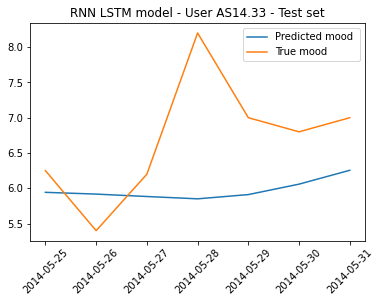

C:\Users\julia\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:682: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


MSE = 0.4863982873851294, RMSE = 0.6974226031504351, R2 = 0.1373223261339751, accuracy = -


In [222]:
%run RNN3_2.ipynb
%run Benchmark2_0.ipynb

In [238]:
import scipy
dicts = [score_f, scores_b, scores_r]
for score in score_f.keys():
    alt = 'less'
    if score == 'r2':
        alt = 'greater'
    print(f'FE vs Benchmark {score}')
    print(scipy.stats.wilcoxon(score_f[score], scores_b[score], alternative=alt))
    
print()    

for score in scores_r.keys():
    alt = 'less'
    if score == 'r2':
        alt = 'greater'
    print(f'RNN vs Benchmark {score}')
    print(scipy.stats.wilcoxon(scores_r[score], scores_b[score], alternative=alt))
    
print()
    
for score in score_f.keys():
    alt = 'less'
    if score == 'r2':
        alt = 'greater'
    print(f'FE vs RNN {score}')
    print(scipy.stats.wilcoxon(score_f[score], scores_r[score], alternative=alt))
    
print()
    
for score in scores_r.keys():
    alt = 'less'
    if score == 'r2':
        alt = 'greater'
    print(f'RNN vs FE {score}')
    print(scipy.stats.wilcoxon(scores_r[score], score_f[score], alternative=alt))
    
print()
    
for score in scores_b.keys():
    alt = 'less'
    if score == 'r2':
        alt = 'greater'
    print(f'Benchmark vs RNN {score}')
    print(scipy.stats.wilcoxon(scores_b[score], scores_r[score], alternative=alt))

FE vs Benchmark mae
WilcoxonResult(statistic=3.0, pvalue=3.935743651233956e-06)
FE vs Benchmark rmse
WilcoxonResult(statistic=3.0, pvalue=3.935743651233956e-06)
FE vs Benchmark r2
WilcoxonResult(statistic=378.0, pvalue=2.8030582637480065e-06)

RNN vs Benchmark mae
WilcoxonResult(statistic=40.0, pvalue=0.00017197808966517626)
RNN vs Benchmark rmse
WilcoxonResult(statistic=21.0, pvalue=2.716197521659241e-05)
RNN vs Benchmark r2
WilcoxonResult(statistic=1.0, pvalue=0.9999968594576109)

FE vs RNN mae
WilcoxonResult(statistic=90.0, pvalue=0.008692210176033091)
FE vs RNN rmse
WilcoxonResult(statistic=122.0, pvalue=0.05373442000829401)
FE vs RNN r2
WilcoxonResult(statistic=351.0, pvalue=4.970040928594088e-05)

RNN vs FE mae
WilcoxonResult(statistic=288.0, pvalue=0.991307789823967)
RNN vs FE rmse
WilcoxonResult(statistic=256.0, pvalue=0.946265579991706)
RNN vs FE r2
WilcoxonResult(statistic=0.0, pvalue=0.9999971969417363)

Benchmark vs RNN mae
WilcoxonResult(statistic=338.0, pvalue=0.999828021